# Delivery Date Prediction

## Get Data

In [1]:
# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

## Import all modues
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pkg.data import get_data
import datetime

In [2]:
## load tables
orders = get_data()['orders'].copy()

items = get_data()['order_items'].copy()

customers = get_data()['customers'].copy()

sellers = get_data()['sellers'].copy()

geo = get_data()['geolocation'].copy()

products = get_data()['products'].copy()

* Listed Necessary Column/Features:
     - Delivery Date (orders)
     - Estimated delivery date (orders)
     - Purchase Date (orders)
     - seller state (sellers)
     - customer state (customers)
     - product_size (products)
     - product_weight (products)
     - Distance of Delivery (derived)

### Get Delivery Distance


* In order to compute distance between the customer and the seller, we need their zip code (associated latitude & longitude)

In [4]:
### Get the seller zip code of each order
middle = items[['order_id', 'seller_id']]
middle_2 = middle.merge(sellers[['seller_id', 'seller_zip_code_prefix']], on = "seller_id", how = "outer")
orders = orders.merge(middle_2, on = "order_id", how = "left")

### Get customer zip code of each order
orders = orders.merge(customers[['customer_id', 'customer_zip_code_prefix']],
             on = 'customer_id', how = "left")


## Clean geo df
geo = geo[~geo['geolocation_zip_code_prefix'].duplicated()]

## add seller coordinates to the orders
orders = orders.merge(geo, 
             left_on = "seller_zip_code_prefix", 
             right_on = "geolocation_zip_code_prefix", 
             how = "left")

## add customer coordinates to the orders
orders = orders.merge(geo, 
             left_on = "customer_zip_code_prefix", 
             right_on = "geolocation_zip_code_prefix", 
             how = "left",
             suffixes = ("_seller", "_customer"))

In [5]:
## Clean orders
## 1--Filter out orders with multipul sellers
# Because each order only has one delivery date

df = orders.groupby(by="order_id").nunique()

mono_orders = pd.Series(df[df['seller_id'] == 1].index)

filtered_orders = orders.merge(mono_orders, how = 'inner')


## 2--drop rows with missing values
#filtered_orders.isna().sum()
filtered_orders = filtered_orders.drop(columns = ["order_approved_at"])

filtered_orders = filtered_orders.dropna()

In [6]:
## define a function to get distance from coordinates
from math import radians, sin, cos, asin, sqrt
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Compute distance between two pairs of (lat, lng)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))

## add distance column to dateset
filtered_orders['distance'] = filtered_orders.apply(
    lambda row: haversine_distance(
        row["geolocation_lng_seller"],
        row["geolocation_lat_seller"],
        row["geolocation_lng_customer"],
        row["geolocation_lat_customer"],
    ),
    axis=1,
)

### Get package size

In [7]:
df_tmp = items[['order_id', 'product_id']].merge(products[['product_id', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']],
                                        on = "product_id",
                                        how = "outer")

df_tmp.loc[:, "product_size_cm3"] = df_tmp['product_length_cm'] * df_tmp['product_width_cm'] * df_tmp['product_height_cm']

orders_size_weight = df_tmp.groupby("order_id", as_index = False).sum()[['order_id','product_size_cm3', 'product_weight_g']]

filtered_orders = filtered_orders.merge(orders_size_weight,
                    on = 'order_id',
                    how = 'left')

### Get wait time 

In [8]:
## Convert time columns
time_columns = ['order_purchase_timestamp',
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date']

for column in time_columns:
    filtered_orders.loc[:, column] = pd.to_datetime(filtered_orders[column])

filtered_orders.loc[:,"wait_time"] = (filtered_orders['order_delivered_customer_date'] - filtered_orders['order_purchase_timestamp']).dt.days

### Clean data

In [134]:
filtered_orders.T

,0,1,2,3,4,5,6,7,8,9,...,106568,106569,106570,106571,106572,106573,106574,106575,106576,106577
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159,a4591c265e18cb1dcee52889e2d8acc3,6514b8ad8028c9f2cc2374ded245783f,76c6e866289321a7c93b82b54852dc33,e69bfb5eb88e0ed6a785585b27e16dbf,e6ce16cb79ec1d90b1da9085a6118aeb,...,9115830be804184b91f5c00f6f49f92d,9115830be804184b91f5c00f6f49f92d,aa04ef5214580b06b10e2a378300db44,880675dff2150932f1601e1c07eadeeb,9c5dedf39a927c1b2549525ed64a053c,63943bddc261676b46f01ca7ac2f7bd8,83c1379a015df1e13d02aae0204711ab,11c177c8e97725db2631073c19f07b62,11c177c8e97725db2631073c19f07b62,66dea50a8b16d9b4dee7af250b4be1a5
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c,503740e9ca751ccdda7ba28e9ab8f608,9bdf08b4b3b52b5526ff42d37d47f222,f54a9f0e6b351c431402b8461ea51999,31ad1d1b63eb9962463f764d4e6e0c9d,494dded5b201313c64ed7f100595b95c,...,da2124f134f5dfbce9d06f29bdb6c308,da2124f134f5dfbce9d06f29bdb6c308,f01a6bfcc730456317e4081fe0c9940e,47cd45a6ac7b9fb16537df2ccffeb5ac,39bd1228ee8140590ac3aca26f2dfe00,1fca14ff2861355f6e5f14306ff977a7,1aa71eb042121263aafbe80c1b562c9c,b331b74b18dc79bcdf6532d51e1637c1,b331b74b18dc79bcdf6532d51e1637c1,edb027a75a1449115f6b43211ae02a24
order_status,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39,2017-07-09 21:57:05,2017-05-16 13:10:30,2017-01-23 18:29:09,2017-07-29 11:55:02,2017-05-16 19:41:10,...,2017-10-04 19:57:37,2017-10-04 19:57:37,2017-01-27 00:30:03,2017-02-23 09:05:12,2017-03-09 09:54:05,2018-02-06 12:58:58,2017-08-27 14:46:43,2018-01-08 21:28:27,2018-01-08 21:28:27,2018-03-08 20:57:30
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34,2017-07-11 14:58:04,2017-05-22 10:07:46,2017-01-26 14:16:31,2017-08-10 19:45:24,2017-05-18 11:40:40,...,2017-10-05 16:52:52,2017-10-05 16:52:52,2017-01-30 11:40:16,2017-03-01 10:22:52,2017-03-10 11:18:03,2018-02-07 23:22:42,2017-08-28 20:52:26,2018-01-12 15:35:03,2018-01-12 15:35:03,2018-03-09 22:11:59
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02,2017-07-26 10:57:55,2017-05-26 12:55:51,2017-02-02 14:08:10,2017-08-16 17:14:30,2017-05-29 11:18:31,...,2017-10-20 20:25:45,2017-10-20 20:25:45,2017-02-07 13:15:25,2017-03-06 11:08:08,2017-03-17 15:08:01,2018-02-28 17:37:56,2017-09-21 11:24:17,2018-01-25 23:32:54,2018-01-25 23:32:54,2018-03-16 13:08:30
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00,2017-08-01 00:00:00,2017-06-07 00:00:00,2017-03-06 00:00:00,2017-08-23 00:00:00,2017-06-07 00:00:00,...,2017-11-07 00:00:00,2017-11-07 00:00:00,2017-03-17 00:00:00,2017-03-22 00:00:00,2017-03-28 00:00:00,2018-03-02 00:00:00,2017-09-27 00:00:00,2018-02-15 00:00:00,2018-02-15 00:00:00,2018-04-03 00:00:00
seller_id,3504c0cb71d7fa48d967e0e4c94d59d9,289cdb325fb7e7f891c38608bf9e0962,4869f7a5dfa277a7dca6462dcf3b52b2,66922902710d126a0e7d26b0e3805106,2c9e548be18521d1c43cde1c582c6de8,8581055ce74af1daba164fdbd55a40de,16090f2ca825584b5a147ab24aa30c86,63b9ae557efed31d1f7687917d248a8d,7c67e1448b00f6e969d365cea6b010ab,001cca7ae9ae17fb1caed9dfb1094831,...,1caf283236cd69af44cbc09a0a1e7d32,1caf283236cd69af44cbc09a0a1e7d32,ccc4bbb5f32a6ab2b7066a4130f114e3,391fc6631aebcf3004804e51b40bcf1e,e24fc9fcd865784fb25705606fe3dfe7,1f9ab4708f3056ede07124aad39a2554,d50d79cb34e38265a8649c383dcffd48,a1043bafd471dff536d0c462352beb48,a

In [9]:
data = filtered_orders[['order_id', 'order_purchase_timestamp',
                'order_delivered_customer_date', 
                 'geolocation_state_customer', 'geolocation_state_seller',
                 'distance',
                 'product_size_cm3', 'product_weight_g',
                 'wait_time',
                 'order_estimated_delivery_date']]
data.loc[:, "count"] = 1

/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [10]:
data.isnull().sum()

order_id                         0
order_purchase_timestamp         0
order_delivered_customer_date    0
geolocation_state_customer       0
geolocation_state_seller         0
distance                         0
product_size_cm3                 0
product_weight_g                 0
wait_time                        0
order_estimated_delivery_date    0
count                            0
dtype: int64

## EDA and Feature Engineering

### Distribution of the target


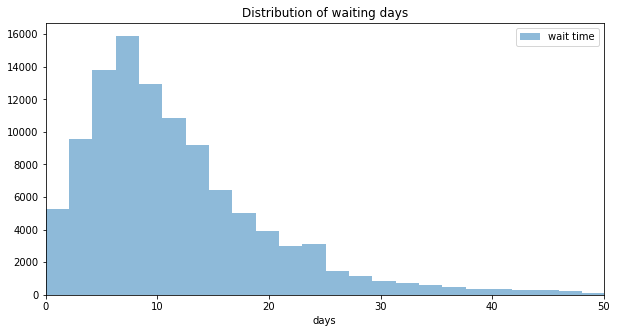

In [45]:
### Distribution of wait-time

plt.figure(figsize = (10, 5))

kwargs = dict(histtype = 'stepfilled', alpha = 0.5, bins = 100)

plt.hist(data['wait_time'], label='wait time', **kwargs)

plt.title("Distribution of waiting days")
plt.xlabel("days")
plt.xlim((0, 50))
plt.legend()

plt.show()

### Explore Temporal Factors

In [92]:
daily_delivery = pd.DataFrame(data.set_index('order_delivered_customer_date').resample('D').sum()['count'])

daily_purchase = pd.DataFrame(data.set_index('order_purchase_timestamp').resample('D').sum()['count'])

daily_delivery.loc[:, "dow"] = daily_delivery.index.dayofweek

daily_purchase.loc[:, "dow"] = daily_purchase.index.dayofweek

In [94]:
import plotly.express as px

fig = px.scatter(daily_purchase, 
                 x=daily_purchase.index, 
                 y="count",
                 size = "count",
                 color = "dow"
                )
fig.show()

In [95]:
# Using plotly.express
import plotly.express as px

fig = px.scatter(daily_delivery, 
                 x=daily_delivery.index, 
                 y="count",
                 size = "count",
                 color = "dow"
                )
fig.show()

In [127]:
daily_purchase.loc[:,"mean_wait_time"] = data.set_index('order_purchase_timestamp').resample("D").mean()['wait_time']

fig = px.scatter(daily_purchase, 
                 x=daily_purchase.index, 
                 y="mean_wait_time",
                 size = "count",
                 color = "dow"
                )
fig.show()

In [11]:
data.loc[:,"purchase_dow"] = data.order_purchase_timestamp.dt.dayofweek

data.loc[:, "year"] = data.order_purchase_timestamp.dt.year

data.loc[:, "purchase_month"] = data.order_purchase_timestamp.dt.month

/Users/moyang/.pyenv/versions/3.8.5/envs/bubble/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [32]:
## Save data to pickle

data.to_pickle("delivery_data")

# pd.read_pickle("delivery_data")

### Geospatial Data

In [46]:
# make sur your install folium first
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [47]:
center_location = [-22.9020, -43.1882]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)

In [49]:
%matplotlib notebook
filtered_orders.loc[:, "count"] =1
heatmap_data = filtered_orders.head(10000)[['geolocation_lat_seller', 'geolocation_lng_seller', 'count']].groupby(['geolocation_lat_seller', 'geolocation_lng_seller']).sum().reset_index().values.tolist()
gradient = {0.1: 'blue', 0.2: 'lime', 0.3: 'orange', 0.4: 'red', 0.5: 'purple', 0.6: 'black'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

## Baseline Score

>Engineer a scoring metric that preserves the magnitude of the target and the direction of the errors made.

In [27]:
def directed_error(y,y_pred):
    '''The difference between estimated delivery time
    and actual delivery time. Positive number (delivered before estimation time) is prefered.'''
    return np.mean(y_pred - y)

y_base = (data['order_estimated_delivery_date'] - data['order_purchase_timestamp']).dt.days

basic_score = directed_error(data['wait_time'], y_base)
basic_score

11.290435174238587

## Model Selection

### Prepare Training data

In [20]:
X = data[['distance', 'geolocation_state_customer', 'geolocation_state_seller',
         'product_size_cm3', 'product_weight_g', 'purchase_dow',
         'year', 'purchase_month']]
y = data['wait_time']

X.head()

,distance,geolocation_state_customer,geolocation_state_seller,product_size_cm3,product_weight_g,purchase_dow,year,purchase_month
0,18.063837,SP,SP,1976.0,500.0,0,2017,10
1,856.292580,BA,MG,4693.0,400.0,1,2018,7
2,514.130333,GO,SP,9576.0,420.0,2,2018,8
3,1822.800366,RN,MG,6000.0,450.0,5,2017,11
4,30.174037,SP,SP,11475.0,250.0,1,2018,2


### Preprocessing

In [21]:
from sklearn.preprocessing import MinMaxScaler

# OneHot encoding
encode_features = ['geolocation_state_customer',
                   'geolocation_state_seller',
                   'year', 'purchase_month',
                   'purchase_dow']

X = pd.get_dummies(X, columns = encode_features)

# scale numerical features
numerical_features = ['distance','product_size_cm3', 'product_weight_g']
scaler = MinMaxScaler()
X.loc[:, numerical_features] = scaler.fit_transform(X[numerical_features])

### LinearRegression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

# Instanciate model
lin_model = LinearRegression()

# Make cross-validated predictions 
y_pred_lin = cross_val_predict(lin_model, X, y, cv=10)

In [28]:
directed_error(y, y_pred_lin)

-0.0004294612224292302

### KNN Rgressor

In [29]:
from sklearn.neighbors import KNeighborsRegressor

# Instanciate model
knn_model = KNeighborsRegressor(n_neighbors=3)

# Make cross-validated predictions 
y_pred_knn = cross_val_predict(knn_model, X, y, cv=10)

directed_error(y, y_pred_knn)

-0.07894374698968519